In [1]:
import espaloma as esp
import mbuild as mb
from openff.toolkit.topology import Molecule
from writers import foyer_xml_writer
from writers.foyer_xml_writer import mbuild_to_foyer_xml
from bondwalk import bond_walk
from bondwalk.bond_walk import MadAtom, MadBond, BondWalker
import ipywidgets as widgets
import os
import torch
import parmed as pmd
import networkx  as nx
if not os.path.exists("espaloma_model.pt"):
    os.system("wget http://data.wangyq.net/espaloma_model.pt")

LICENSE: Could not open license file "oe_license.txt" in local directory
LICENSE: N.B. OE_LICENSE environment variable is not set
LICENSE: N.B. OE_DIR environment variable is not set
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!
LICENSE: No product keys!


In [4]:
# Small fragments with high electronegtive groups (Oxygen, Nitrogen, Fluorine, Chlorine, etc..)
phenol = mb.load("c1ccc(O)cc1",smiles=True)
pyridine = mb.load("c1cnccc1",smiles=True)
conj_fluorine = mb.load("c1cc2ccc(F)cc2cc1" ,smiles=True)
conj_chlorine = mb.load("c1cc2ccc(Cl)cc2cc1",smiles=True)
conj_sulphur = mb.load("c1cc2ccc(S)cc2cc1",smiles=True)

# Larger, bulky conjugated structures, only contain carbon and hydrogen:
perylene = mb.load("c1cc2cccc3c4cccc5cccc(c(c1)c23)c45",smiles=True) 
tetracene = mb.load("c1c2cc3cc4ccccc4cc3cc2ccc1",smiles=True)

# Long aliphatic side group:
alkane_chain = mb.load("CCCCCCCCCCCCCC",smiles=True)

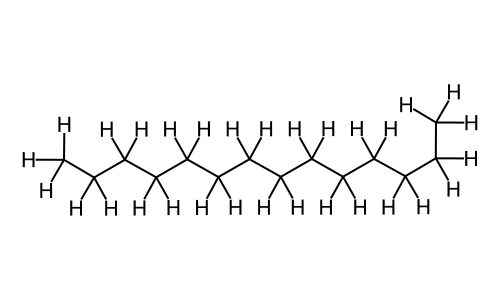

In [6]:
smiles = alkane_chain.to_smiles()
comp = Molecule.from_smiles(smiles)
comp.visualize()

In [7]:
#comp = Molecule.from_smiles(SMILES)
#bonds = [b for b in comp.bonds]
#for i in range(len(bonds)):
#    bonds[i].bond_order = 1
#b= BondWalker(comp)
#molecule = b.fill_in_bonds()
molecule = comp
molecule_graph = esp.Graph(molecule)
espaloma_model = torch.load("espaloma_model.pt")
espaloma_model(molecule_graph.heterograph)
openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph,charge_method="nn")

In [ ]:
def espaloma(SMILES,XML_FILEPATH,TYPED_FILEPATH):
    #comp = Molecule.from_smiles(SMILES)
    #bonds = [b for b in comp.bonds]
    #for i in range(len(bonds)):
    #    bonds[i].bond_order = 1
    #b= BondWalker(comp)
    #molecule = b.fill_in_bonds()
    molecule = 
    molecule_graph = esp.Graph(molecule)
    espaloma_model = torch.load("espaloma_model.pt")
    espaloma_model(molecule_graph.heterograph)
    openmm_system = esp.graphs.deploy.openmm_system_from_graph(molecule_graph,charge_method="nn")

    # Store the results for each in something more accessible
    pair_forces = openmm_system.getForces()[1]
    angle_forces = openmm_system.getForces()[3]
    bond_forces = openmm_system.getForces()[2]
    torsion_forces = openmm_system.getForces()[0]

    # get a parmed structure from openmm
    topology = molecule.to_topology()
    openmm_topology = topology.to_openmm()

    structure = pmd.openmm.load_topology(topology=openmm_topology, system=openmm_system)
    structure.bonds.sort(key=lambda x: x.atom1.idx)



    for i in range(len(molecule.atoms)):
        if molecule.atoms[i].atomic_number == 6:
            molecule.atoms[i].name = 'C'
        if molecule.atoms[i].atomic_number == 1:
            molecule.atoms[i].name = 'H'
        if molecule.atoms[i].atomic_number == 7:
            molecule.atoms[i].name = 'N'
        if molecule.atoms[i].atomic_number == 16:
            molecule.atoms[i].name = 'S'
        if molecule.atoms[i].atomic_number == 8:
            molecule.atoms[i].name = 'O'
        if molecule.atoms[i].atomic_number == 9:
            molecule.atoms[i].name = 'F'

    #generate type_map:
    Gopenmm = nx.Graph()
    Gparmed = nx.Graph()

    #openmm:
    for i in range(bond_forces.getNumBonds()):
        Gopenmm.add_edge(bond_forces.getBondParameters(index=i)[0],bond_forces.getBondParameters(index=i)[1])
    #parmed
    for b in structure.bonds:
        Gparmed.add_edge(b.atom1.idx,b.atom2.idx)

    particle_types = []
    type_map = dict()

    #nx.rooted_tree_isomorphism
    #in here we still need to check that one known index on one corresponds to the same index on the other....
    tree_openmm = nx.bfs_tree(Gopenmm,0)
    tree_parmed = nx.bfs_tree(Gparmed,0)
    if nx.is_isomorphic(Gopenmm,Gparmed):
    #if nx.isomorphism.tree_isomorphism(tree_openmm,tree_parmed):  <- want this work
        for i in range(pair_forces.getNumParticles()):
            pair_parms = pair_forces.getParticleParameters(index=i)
            sigma = pair_parms[1]/pair_parms[1].unit
            epsilon = pair_parms[2]/pair_parms[2].unit
            if (sigma, epsilon) not in particle_types:
                particle_types.append((sigma, epsilon))
            type_map[molecule.atoms[i].molecule_atom_index] = "".join([molecule.atoms[i].name ,
                                                                       str(particle_types.index((sigma, epsilon)))])


    #generate dictionaries:

    bond_types = []
    bond_dict = dict()

    for i in range(bond_forces.getNumBonds()):
        bond_parms = bond_forces.getBondParameters(index=i)
        l0 = bond_parms[2]/bond_parms[2].unit
        k = bond_parms[3]/bond_parms[3].unit
        bond_dict[type_map[bond_parms[0]],type_map[bond_parms[1]]] = {'k':k,'l0':l0}


    angle_types = []
    angle_dict = dict()

    for i in range(angle_forces.getNumAngles()):
        angle_parms = angle_forces.getAngleParameters(index=i)
        k = angle_parms[4]/angle_parms[4].unit
        t0 = angle_parms[3]/angle_parms[3].unit
        angle_dict[type_map[angle_parms[0]],type_map[angle_parms[1]],type_map[angle_parms[2]]] = {'k':k,'t0':t0}



    dihedral_types = []
    dihedral_dict = {}

    for i in range(torsion_forces.getNumTorsions()):
        if i%6==0:
            periodicity=[]
            phase = []
            k = []
        dihedral_parms = torsion_forces.getTorsionParameters(index=i)
        periodicity.append(dihedral_parms[4])
        phase.append( dihedral_parms[5]/dihedral_parms[5].unit)
        k.append(dihedral_parms[6]/dihedral_parms[6].unit)
        dt = (type_map[dihedral_parms[0]],type_map[dihedral_parms[1]],type_map[dihedral_parms[2]],
                      type_map[dihedral_parms[3]])


        if periodicity[-1]==6:
            dihedral_dict[dt] = {'periodicity':periodicity,'k':k,'phase':phase}


    nonbonded_types = []
    nonbonded_dict = {}

    for i in range(pair_forces.getNumParticles()):
        nonbonded_parms = pair_forces.getParticleParameters(index=i)
        charge = nonbonded_parms[0]/nonbonded_parms[0].unit
        sigma = nonbonded_parms[1]/nonbonded_parms[1].unit
        epsilon = nonbonded_parms[2]/nonbonded_parms[2].unit
        nonbonded_types.append((charge,sigma,epsilon))
        nonbonded_dict[(type_map[i])]={'charge':charge,'sigma':sigma,'epsilon':epsilon}

    molecule.to_file('molecule.mol',file_format='mol')
    os.system('obabel molecule.mol -O intermediate.mol2')
    os.system('rm molecule.mol')

    test = mb.load('intermediate.mol2')

    for index in type_map:
       #print(index, type_map[index],comp_rename[index].name)
        test[index].name = type_map[index]

    os.system('rm intermediate.mol2')

    t1 = test.children[0]
    t2 = test.children[1]
    t3 = test.children[2]
    t4 = test.children[3]

    test.remove(objs_to_remove=t2)
    test.remove(objs_to_remove=t4)

    test.energy_minimize()

    mbuild_to_foyer_xml(
        file_name=XML_FILEPATH,
        compound=test,
        bond_params=bond_dict,
        angle_params=angle_dict,
        dihedral_params=dihedral_dict,
        dihedral_type="periodic",
        non_bonded_params=nonbonded_dict,
        combining_rule="geometric",
        name="",
        version="",
        coulomb14scale=1.0,
        lj14scale=1.0)

    test.save(TYPED_FILEPATH,overwrite=True)

    return test